# Housing Price Estimation
## Matt Wong


This little project 

In [66]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 20

# The Data

The [Ames dataset](http://jse.amstat.org/v19n3/decock.pdf) consists of 2930 records taken from the Ames, Iowa, Assessor’s Office describing houses sold in Ames from 2006 to 2010.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total. The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.

The data are split into training and test sets with 2000 and 930 observations, respectively.

In [2]:
training_data = pd.read_csv("data/ames_train.csv")
test_data = pd.read_csv("data/ames_test.csv")

As a good sanity check, we should at least verify that the data shape matches the description.

In [3]:
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)
# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)
# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know such as lot size, neighborhood, year sold, etc. 

In [4]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# Part 1: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (a combination of a KDE, a histogram, a strip plot, and a box plot) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

C:\Users\Bear\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Bear\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Bear\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


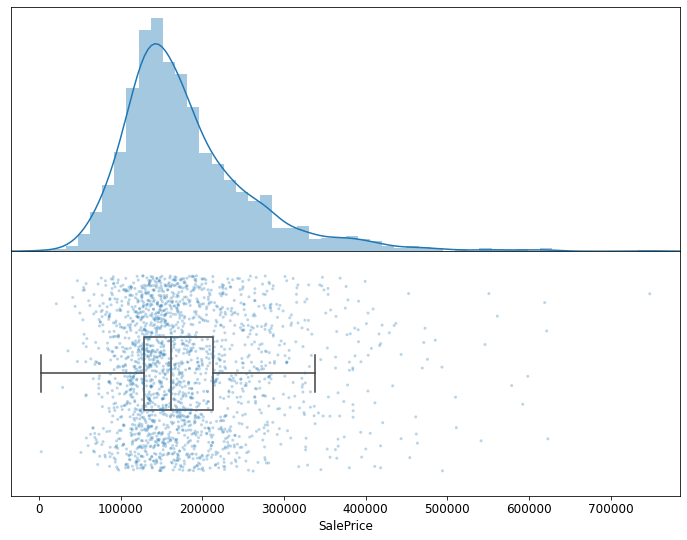

In [5]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'], 
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [6]:
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

Our visualization allows us to see that the training set is fairly normal with a mean greater than the median value. 

### SalePrice vs Gr_Liv_Area

Next, let's visualize the association between `SalePrice` and `Gr_Liv_Area`.  The `codebook.txt` file tells us that `Gr_Liv_Area` measures "above grade (ground) living area square feet."

This variable represents the square footage of the house excluding anything underground.  Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

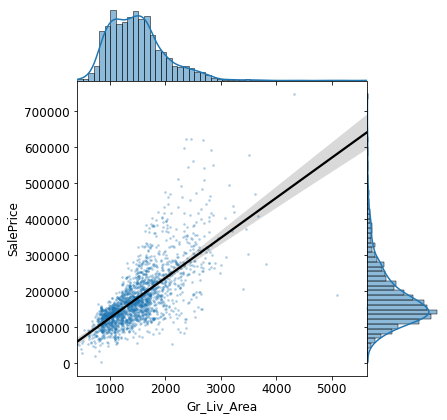

In [7]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

There's certainly an association, and perhaps it's linear, but the spread is wider at larger values of both variables.  Also, there are two particularly suspicious houses above 5000 square feet that look too inexpensive for their size.

We can use Beacon, an online database, to manually inspect the houses. These two houses are true outliers in this data set: they aren't the same time of entity as the rest. They were partial sales, priced far below market value. If you would like to inspect the valuations, follow the directions at the bottom of the codebook to access Beacon and look up houses by PID.

I'd like to remove these outliers from the data.

In [8]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf): 
    sorted_data = data.sort_values(variable)
    return sorted_data[(sorted_data[variable] > lower) & (sorted_data[variable])<=upper] 

training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

In [9]:
training_data.head(10)

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
870,1303,902205070,20,RM,62.0,7311,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,3,2008,WD,Abnorml,54400
612,908,909175080,30,RL,60.0,8400,Pave,NaN,Reg,Bnk,...,0,NaN,NaN,NaN,0,1,2009,WD,Normal,51100
1968,2881,911175430,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml,41011
1799,2654,902206020,30,RM,52.0,7830,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,55500
1940,2844,909101330,30,RL,60.0,8088,Pave,Grvl,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2006,ConLD,Normal,28700
903,1350,903235100,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,60600
211,303,910203250,30,RM,58.0,8154,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,ConLw,Normal,91900
1404,2084,905476170,30,RL,58.0,9098,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,92900
488,709,902205010,30,RM,50.0,5925,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,53900
1087,1601,923228420,180,RM,21.0,1890,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,72800


# Feature Engineering

In this section we will create a new feature out of existing ones through simple data transformation.

### Bathrooms

Let's assume the Total number of bathrooms can be calculated using the following

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$


let's construct a TotalBathrooms column in accordance to the above operationalization.

In [10]:
def add_total_bathrooms(data):
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    x = with_bathrooms[bath_vars]
    with_bathrooms["TotalBathrooms"] = (x*weights).sum(axis=1)
    return with_bathrooms.fillna(0)

training_data = add_total_bathrooms(training_data)

### It's a pretty good guess that the total number of bathrooms is positively associated with price. Let's see if my hunch is correct.

<Figure size 1152x576 with 0 Axes>

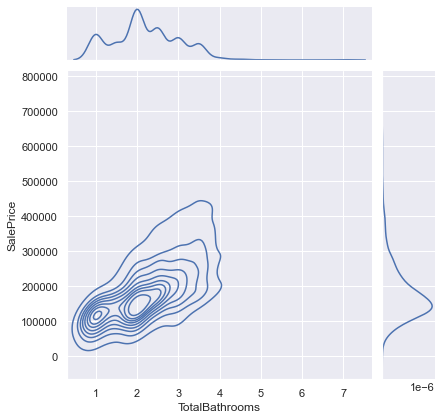

In [11]:
sns.set()
plt.figure(figsize=(16,8))
sns.jointplot(x="TotalBathrooms",y="SalePrice",data=training_data,kind="kde")

It seems we might be onto something! Our KDE plot shows most houses in the dataset have 1-2 bathrooms priced at around 150K. The CEF of the joint density shown is increasing so there's a positive association between number of bathrooms and price. 

# Modeling

We've reached the point where we can specify a model. 

In [12]:
# Load a fresh copy of the data and get its length
full_data = pd.read_csv("data/ames_train.csv")
full_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700


In [13]:
len(full_data)

2000

We should perform our train-test split now before we do anything~

In [14]:
shuffled_indices = np.random.permutation(len(full_data))
shuffled_length = len(shuffled_indices)

train_indices = shuffled_indices[:(int(shuffled_length*.8))]
test_indices = shuffled_indices[int(shuffled_length*.8):]


train = full_data.loc[train_indices]
test = full_data.iloc[test_indices]


### Data Pipeline 

I want to make a pipeline here so that my data remains clean and also for sake of generalizability. 

In [15]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

Now, we can use `process_data_gm` to clean our data, select features, and add our `TotalBathrooms` feature all in one step! This function also splits our data into `X`, a matrix of features, and `y`, a vector of sale prices. 

The following cell constructs our train and test data with added features. 

In [16]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm(train)
X_test, y_test = process_data_gm(test)

## First Model

My first model will be as follows:

$$\text{SalePrice} = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + \theta_3 \cdot \text{TotalBathrooms}$$

Let's implement it 

In [17]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression()
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)

Let's use RMSE to see how well our model is doing. 

$$\text{RMSE} = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in data set}}}$$


In [18]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual-predicted)**2))

In [19]:
training_error = rmse(y_train,y_fitted)
test_error = rmse(y_test,y_predicted)
(training_error, test_error)

(46680.72460275729, 54711.21601260724)

So my model is off by about 46K. Let's investigate a residual plot to see if there's a way we can reduce our error.

### Residual Plots

C:\Users\Bear\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


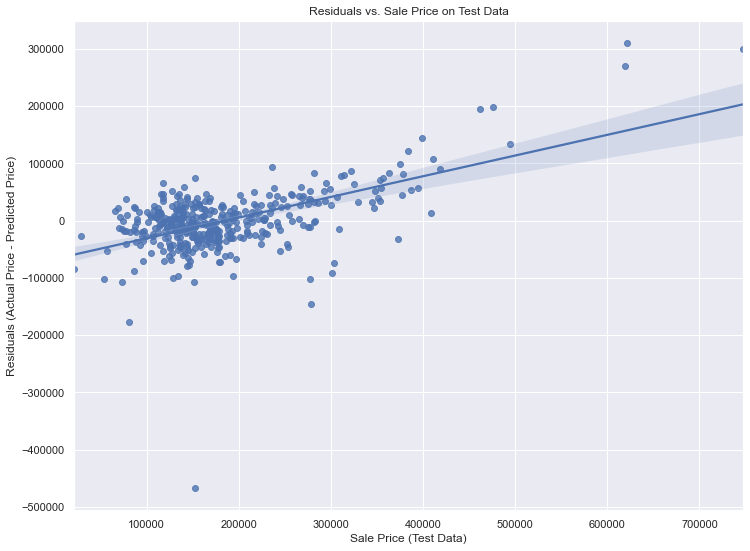

In [20]:
residuals = y_test - y_predicted
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Test Data");

Unfortunately our plot is not mean 0 which means that our model is biased. To fix this, we might consider a larger training set or fit the non linear target variable with a non linear model.

## Neighborhood vs Sale Price

First, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set. I think it might be a good feature to add to our next model.

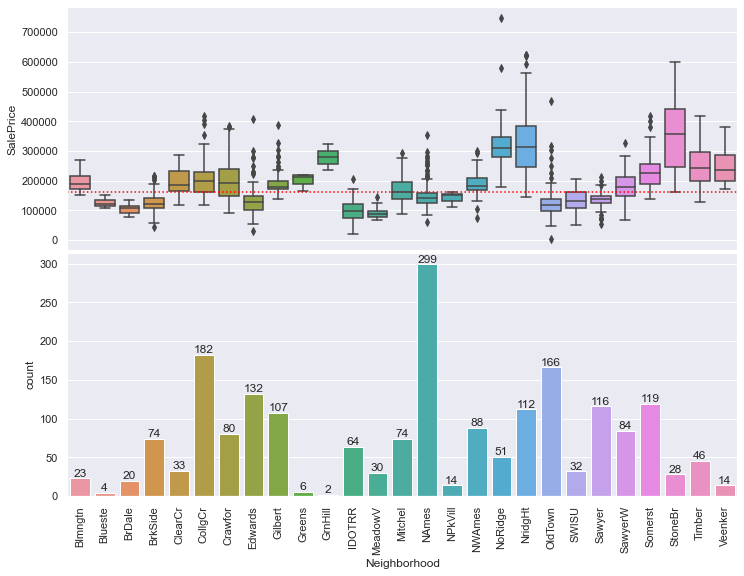

In [21]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

You can see that in general, less populated neighborhoods have a greater sale price while more populated neighborhoods tend to have lower ones. This makes sense intuitively but also doesn't consider factors such as distance to work, groceries, public transport,etc. 

For now, let's just bin together the top 5 wealthiest neigborhoods for our constructed feature. 

In [22]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = list(data.groupby("Neighborhood").agg(metric).sort_values("SalePrice",ascending=False).reset_index()["Neighborhood"][0:n])
    return neighborhoods

def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    isInHood = data["Neighborhood"].isin(neighborhoods).astype("int64")
    data['in_rich_neighborhood'] = isInHood
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

In [23]:
training_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms,in_rich_neighborhood
870,1303,902205070,20,RM,62.0,7311,Pave,0,Reg,Lvl,...,0,0,0,3,2008,WD,Abnorml,54400,1.0,0
612,908,909175080,30,RL,60.0,8400,Pave,0,Reg,Bnk,...,0,0,0,1,2009,WD,Normal,51100,1.0,0
1968,2881,911175430,20,C (all),50.0,9000,Pave,0,Reg,Lvl,...,0,0,0,10,2006,WD,Abnorml,41011,1.0,0
1799,2654,902206020,30,RM,52.0,7830,Pave,0,Reg,Lvl,...,0,0,0,6,2006,WD,Normal,55500,2.0,0
1940,2844,909101330,30,RL,60.0,8088,Pave,Grvl,Reg,Lvl,...,0,0,0,2,2006,ConLD,Normal,28700,1.0,0


# Categorical Variables

Let's try and wrangle some categorical variables using encoding. Heads up, NA values in the `Fireplace_Qu` column don't denote missing values, but rather no fireplace at all. Let's keeep this in mind for our operationalization.

In [32]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    data["Fireplace_Qu"].replace(["Ex","Gd","TA","Fa","Po",0],["Excellent","Good","Average","Fair","Poor","No Fireplace"],inplace = True)
    return data

And now for the One Hot Encoding~

In [36]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data.loc[:, 'Fireplace_Qu'] = data.loc[:, 'Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

I think our new features should improve our model. Only one way to find out!

My new model will be this: 

$$\begin{align}
\text{SalePrice} & = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + 
\theta_3 \cdot \text{TotalBathrooms} + \theta_4 \cdot \text{in_rich_neighborhood} + \\
& \quad \: \theta_5 \cdot \text{fpq_Good} + \theta_6 \cdot \text{fpq_Average} + \theta_7 \cdot \text{fpq_Fair} +
\theta_8 \cdot \text{fpq_Poor} + \theta_9 \cdot \text{fpq_No_Fireplace}
\end{align}$$

In [26]:
train.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
479,694,902103100,50,RM,68.0,4080,Pave,Grvl,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,120300
1471,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,190950
1064,1566,914467050,60,RL,NaN,11050,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,205100
977,1450,907202240,20,RL,40.0,14330,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,155000
359,517,528456240,20,FV,75.0,7862,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,199200


In [40]:
#new pipeline
def process_data_model2(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'fpq_Good',
                          'fpq_Average',
                          'fpq_Fair',
                          'fpq_Poor',
                          'fpq_No Fireplace',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y
train = training_data.iloc[train_indices]
test = training_data.iloc[test_indices]
X_train2, y_train2 = process_data_model2(train)
X_test2, y_test2 = process_data_model2(test)

C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [44]:
model2 = lm.LinearRegression()
model2.fit(X_train2,y_train2)
print(["Test Error","Train Error"])
[rmse(model2.predict(X_test2),y_test2),rmse(model2.predict(X_train2),y_train2)]

['Test Error', 'Train Error']


[43531.65228037637, 40929.073574299546]

Our error has lowered significantly! However since it's still a linear model so I think we can do better.

# Final Model

I'm going to fix the NA values in each column by replacing with the mean. I'll also be incorporating fence quality into the model. 

In [60]:
final_model = lm.LinearRegression(fit_intercept=True) # No need to change this!

def process_data_fm(data):
    data= fix_fireplace_qu(data)
    data = fix_fence(data)
    col_list = ["Overall_Qual","Overall_Cond","Year_Built","Fireplaces",
                "Garage_Cars","Yr_Sold","in_rich_neighborhood","Mo_Sold",
                "Bedroom_AbvGr","Year_Remod/Add","Lot_Frontage","Full_Bath","TotalBathrooms","Gr_Liv_Area"]
    ohe_list = [["Utilities",["AllPub","NoSewr","NoSeWa","ELO"]],
                ["Central_Air",["Y","N"]],
                ["Exter_Cond",["Ex","Gd","TA","Fa","Po"]],
                ["Sale_Condition",["Normal","Abnormal","AdjLand","Alloca","Family","Partial"]]
               ]
    data = add_in_rich_neighborhood(data,rich_neighborhoods)
    for j in col_list:
        data = fill_with_mean(data,j)
    input_list= col_list+["Utilities","Central_Air","Sale_Condition","Exter_Cond","Fireplace_Qu","Fence","SalePrice"]
    data = data.loc[:,input_list]
    for i in ohe_list:
        data = ohe(data,i[0],i[1],i[0][0:2])
    data = ohe_fireplace_qu(data)
    data = ohe(data,"Fence",["Good Privacy","Min Privacy","Good Wood","Min Wood/Wire","No Fence"],"Fen")
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    return X, y

def fill_with_mean(df,column_name):
    mean = df[column_name].mean()
    df[column_name] = df[column_name].fillna(value=mean)
    return df
def ohe(df,column_name,cats,abbrev):
    cat_type = CategoricalDtype(categories=cats)
    df.loc[:, column_name] = df.loc[:, column_name].astype(cat_type)
    df = pd.get_dummies(df,
                          prefix=abbrev,
                          columns=[column_name], 
                          drop_first=True)
    
    return df
def fix_fence(df):
    df["Fence"].replace(["GdPrv","MnPrv","GdWo","MnWw",None],["Good Privacy","Min Privacy","Good Wood","Min Wood/Wire","No Fence"],inplace=True)
    return df

In [61]:
X_train_final, y_train_final = process_data_fm(train)
X_test_final, y_test_final = process_data_fm(test)

C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-22-bea3d00e810a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_rich_neighborhood'] = isInHood
<ipython-input-60-3848833dc73d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [63]:
final_model = lm.LinearRegression()
final_model.fit(X_train_final,y_train_final)
print(["Train Accuracy","Test Accuracy"])
[rmse(final_model.predict(X_train_final),y_train_final),rmse(final_model.predict(X_test_final),y_test_final)]

['Train Accuracy', 'Test Accuracy']


[33690.94625018177, 37185.6825882619]

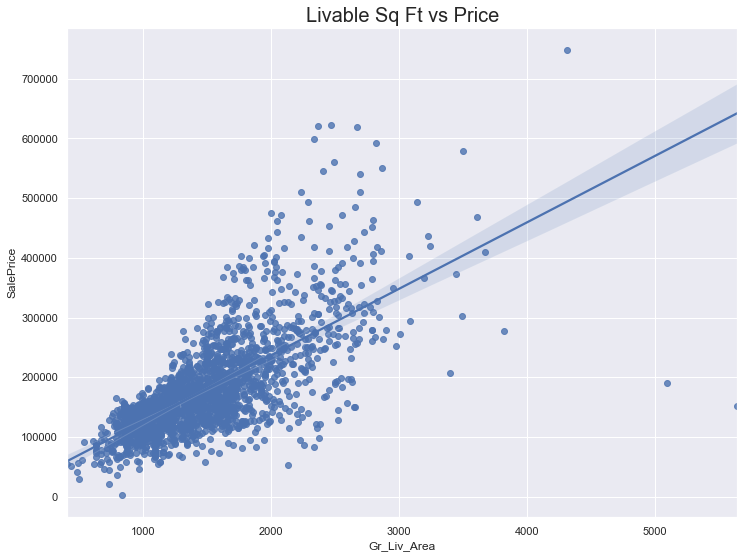

In [68]:
sns.regplot(data=training_data,x="Gr_Liv_Area",y="SalePrice")
plt.title("Livable Sq Ft vs Price",size=20);

In [58]:
training_data.corr("pearson").loc["Gr_Liv_Area","SalePrice"]

0.7012765479145686

The feature that changed my error the most, "Gr_Liv_Area" has a Pearson correlation of .70 with "SalePrice". Because of this, I added it to my model and it decreased my error by around 4000$. This iterative modelling approach has decreased my test error significantly!